# Medical Cost Analysis

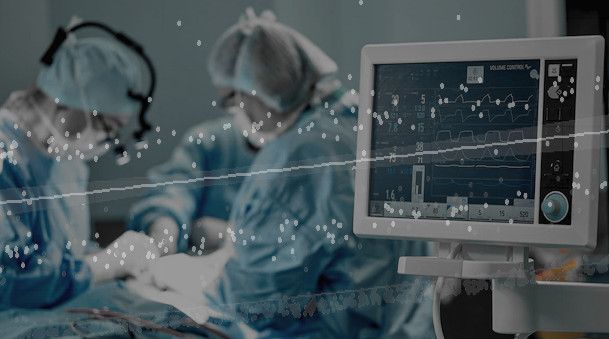

# Importing Required Libraries

In [1]:
# EDA için kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

# Grafikleri göstermek için
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 6

# Makine öğrenmesi algoritmaları, veri ön işleme ve değerlendirme için sklearn kütüphanesi
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, auc

# Uyarılardan kurtulmak için
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [2]:
insurance = pd.read_csv("insurance.csv")
df = insurance.copy()

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
def SuperInfo(df, dropna=False):
    """
    Returns a dataframe consisting of datatypes, nuniques, #s of nulls head(1), most frequent item and its frequncy,
    where the column names are indices.
    """
    dt=pd.DataFrame(df.dtypes, columns=["Type"])
    dn=pd.DataFrame(df.nunique(), columns=["Nunique"])
    nonnull=pd.DataFrame(df.isnull().sum(), columns=["#of Missing"])
    firstT=df.head(1).T.rename(columns={0:"First"})
    MostFreqI=pd.DataFrame([df[x].value_counts().head(1).index[0] for x in df.columns], columns=["MostFreqItem"],index=df.columns)
    MostFreqC=pd.DataFrame([df[x].value_counts().head(1).values[0] for x in df.columns], columns=["MostFreqCount"],index=df.columns)
    return pd.concat([dt,dn,nonnull,MostFreqI,MostFreqC,firstT],axis=1)

In [5]:
SuperInfo(df, dropna=False)

,Type,Nunique,#of Missing,MostFreqItem,MostFreqCount,First
age,int64,47,0,18,69,19
sex,object,2,0,male,676,female
bmi,float64,548,0,32.3,13,27.9
children,int64,6,0,0,574,0
smoker,object,2,0,no,1064,yes
region,object,4,0,southeast,364,southwest
charges,float64,1337,0,1639.5631,2,16884.924


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


# EDA and VIS

## PairPlot and HeatMap for Correlation

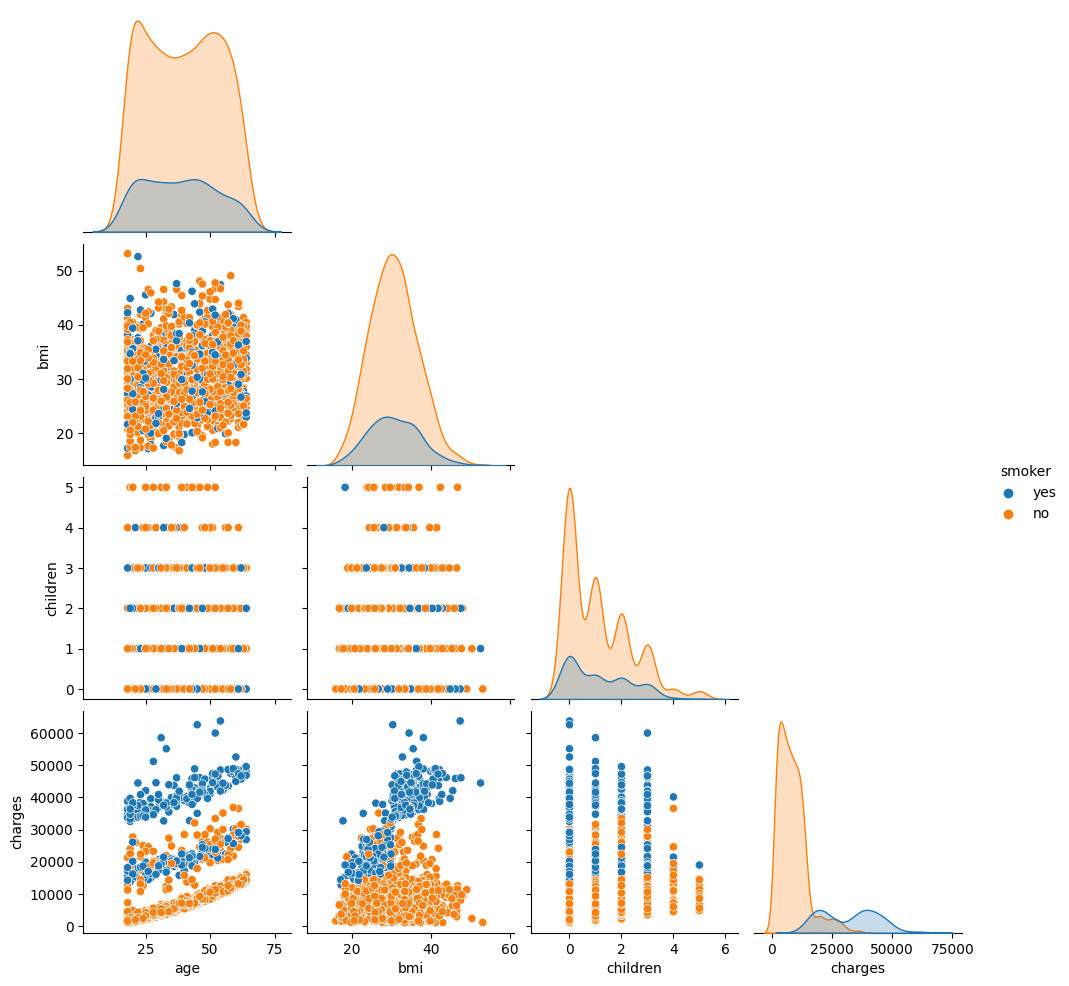

In [8]:
sns.pairplot(df, hue = "smoker",corner = True)

* Smokers are significantly segregated in the charges column. 
 Smokers have much higher health expenditures

In [9]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<AxesSubplot:>

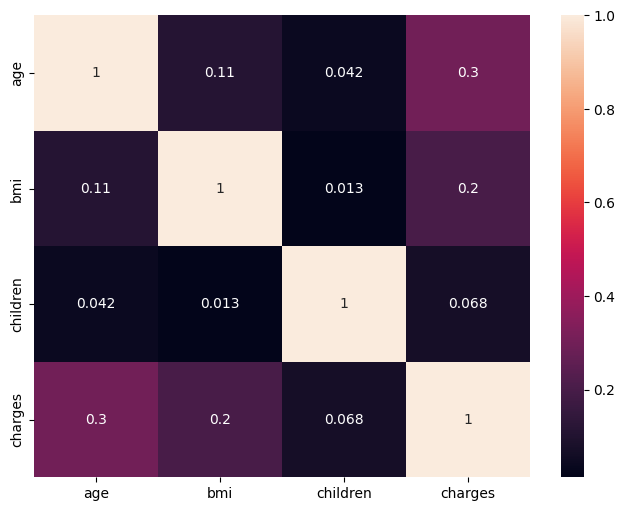

In [10]:
sns.heatmap(df.corr(), annot = True)

In [11]:
df.charges.value_counts()

1639.56310     2
16884.92400    1
29330.98315    1
2221.56445     1
19798.05455    1
              ..
7345.08400     1
26109.32905    1
28287.89766    1
1149.39590     1
29141.36030    1
Name: charges, Length: 1337, dtype: int64

## Examine the distribution of Bmi (Body Mass Index)

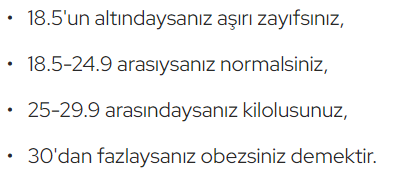

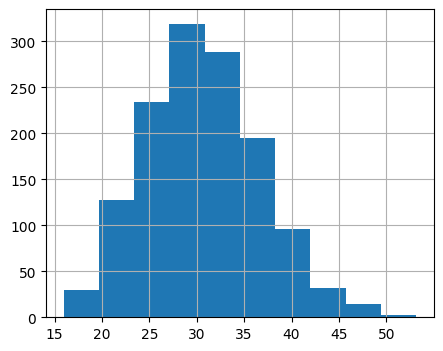

In [12]:
df["bmi"].hist(figsize = (5,4));

*   Normal distribution is observed. Considering that those above 
   30 are obese, about half of the observations can be called obese.

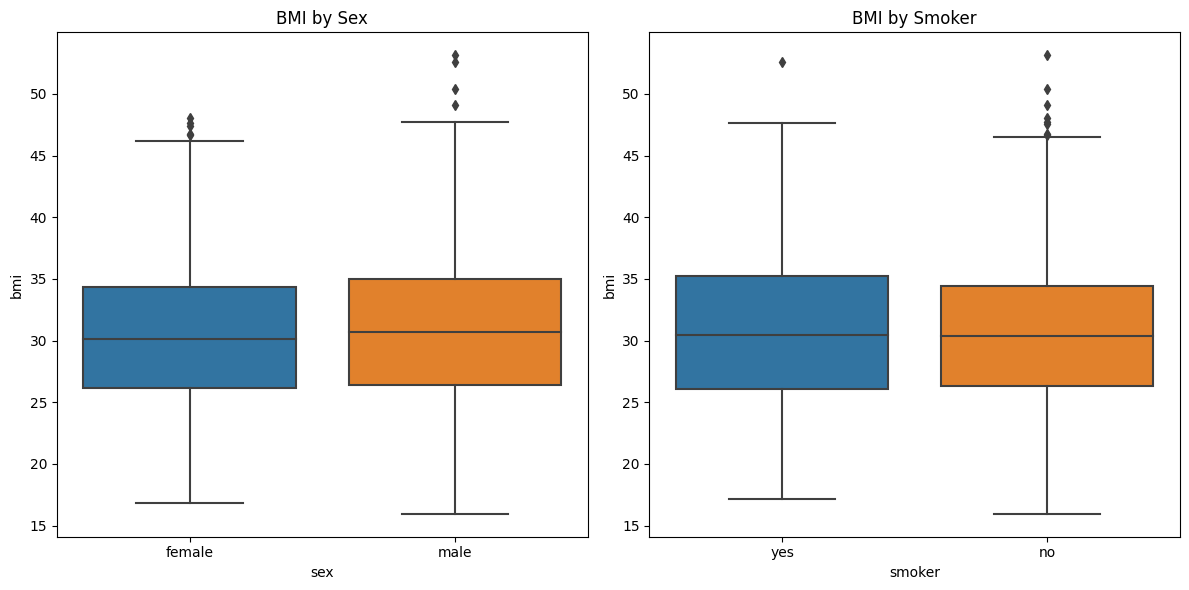

In [13]:
plt.figure(figsize=(12, 6))  
plt.subplot(1, 2, 1)  
sns.boxplot(data=df, y="bmi", x="sex")
plt.title("BMI by Sex")

plt.subplot(1, 2, 2) 
sns.boxplot(data=df, y="bmi", x="smoker")
plt.title("BMI by Smoker")

plt.tight_layout()        
plt.show()                  

* Men have a slightly higher BMI than women. Smokers also have a higher BMI than non-smokers

In [14]:
df.bmi.describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

In [15]:
df[df.bmi > 30].shape

(705, 7)

## Examine the relationship between “smoker” and “charges”

Text(0.5, 1.0, 'charges by smoker')

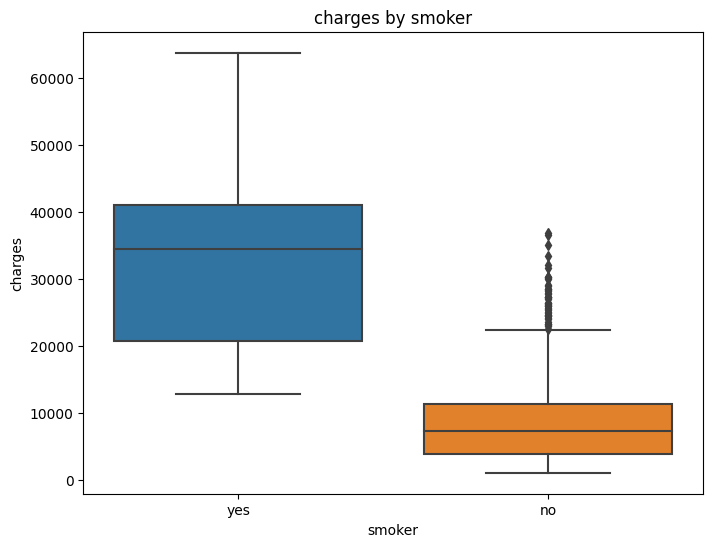

In [16]:
sns.boxplot(data=df, y="charges", x="smoker")
plt.title("charges by smoker")      

 * There is a significant increase in health expenditures for smokers

## Examine the relationship between “smoker” and “region”.

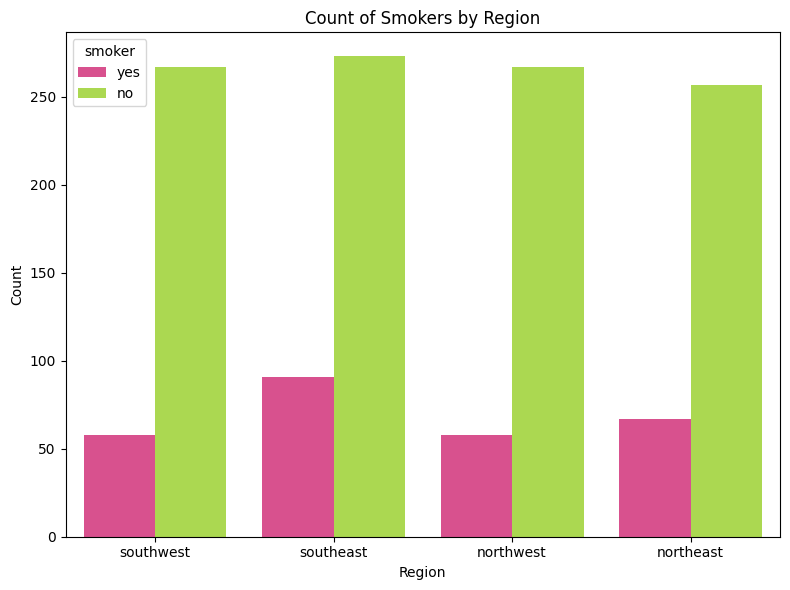

In [17]:


plt.figure(figsize=(8, 6))  
custom_palette = ["#ee3a8c", "#b3ee3a"] 
sns.set_palette(custom_palette)

sns.countplot(data=df, x="region", hue="smoker")
plt.title("Count of Smokers by Region")
plt.xlabel("Region")
plt.ylabel("Count")

plt.tight_layout()
plt.show()           

* More smokers in southeast region

## Examine the relationship between “bmi” and “sex”

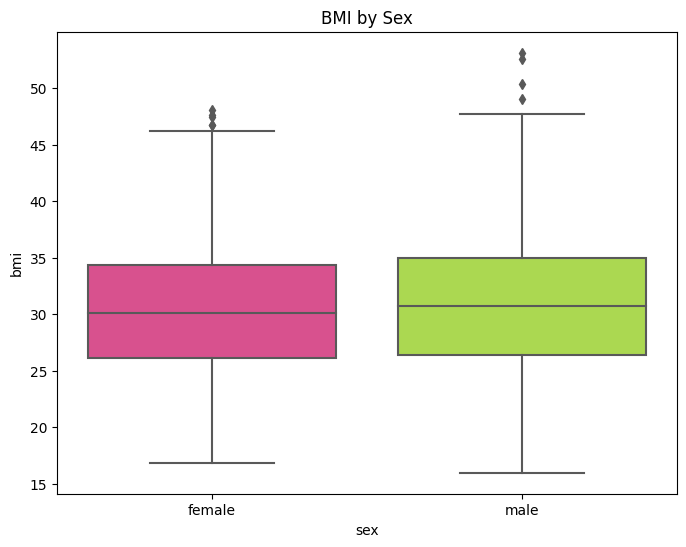

In [18]:
sns.boxplot(data=df, y="bmi", x="sex")
plt.title("BMI by Sex");

* Men have more outliers, their average bi is slightly higher than women.

In [19]:
df.groupby("sex")["bmi"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,662.0,30.377749,6.046023,16.815,26.125,30.1075,34.31375,48.07
male,676.0,30.943129,6.140435,15.960,26.410,30.6875,34.99250,53.13


In [20]:
df.groupby("smoker")["charges"].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1064.0,8434.268298,5993.781819,1121.8739,3986.438700,7345.40530,11362.887050,36910.60803
yes,274.0,32050.231832,11541.547176,12829.4551,20826.244213,34456.34845,41019.207275,63770.42801


##  Find the "region" with the most "children

In [21]:
df.groupby("region")["children"].sum().sort_values(ascending=False) 

region
southeast    382
northwest    373
southwest    371
northeast    339
Name: children, dtype: int64

* The number of children by region is close. 
  Southeast region with the highest number of children

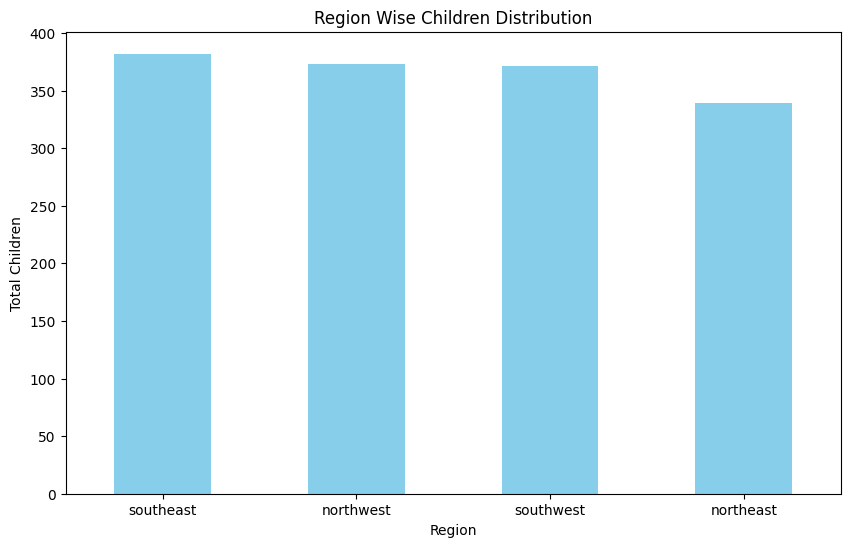

In [22]:
grouped_data = df.groupby("region")["children"].sum().sort_values(ascending=False)

# Çubuk grafik çizimi
plt.figure(figsize=(10, 6))
grouped_data.plot(kind="bar", color="skyblue")
plt.title("Region Wise Children Distribution")
plt.xlabel("Region")
plt.ylabel("Total Children")
plt.xticks(rotation=0)
plt.show()

## Examine the relationship between “age” and “bmi”.

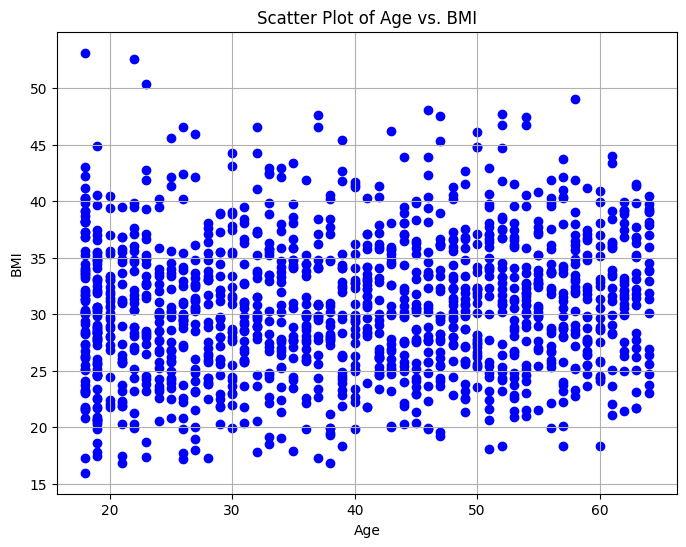

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(df["age"], df["bmi"], color='blue', marker='o')
plt.title('Scatter Plot of Age vs. BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

* For every age group, we can observe various bmi result.

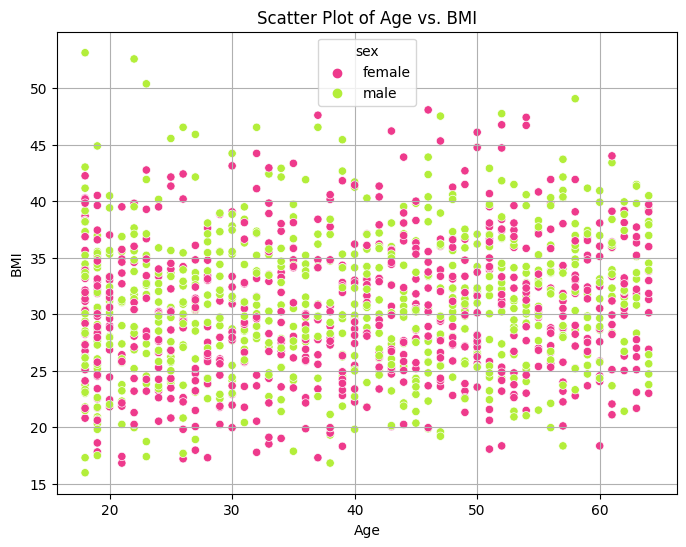

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df["age"], df["bmi"], hue=df["sex"], marker='o')
plt.title('Scatter Plot of Age vs. BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

* For every age group, we can observe various bmi result with respect to sex.

## Examine the relationship between “bmi” and “children”

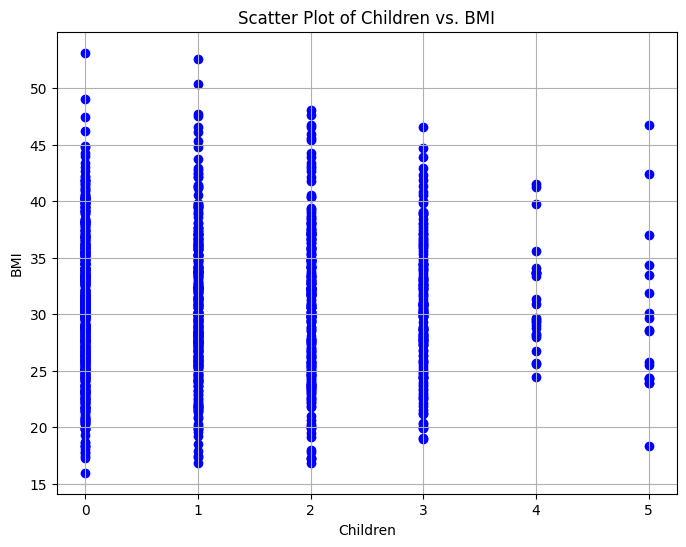

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(df["children"], df["bmi"], color='blue', marker='o')
plt.title('Scatter Plot of Children vs. BMI')
plt.xlabel('Children')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

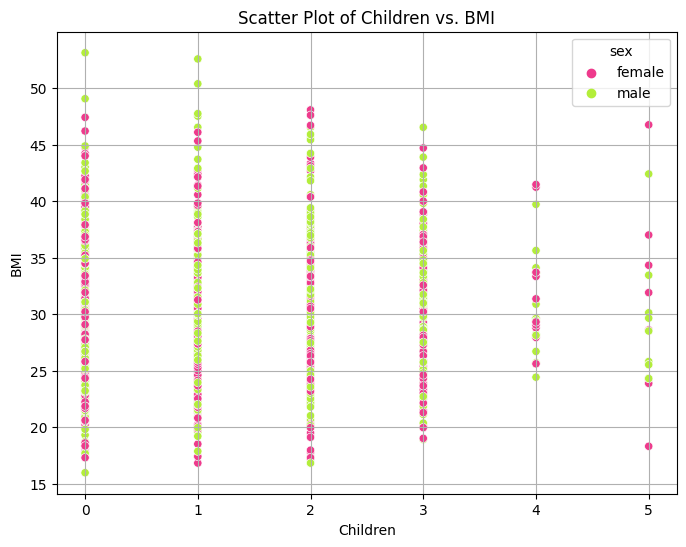

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df["children"], df["bmi"], hue=df["sex"], color='blue', marker='o')
plt.title('Scatter Plot of Children vs. BMI')
plt.xlabel('Children')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

* BMI values narrow as the number of children increases. People who has 5 children have outliers for that inference.

## Is there an outlier in the "bmi" variable? Please review.

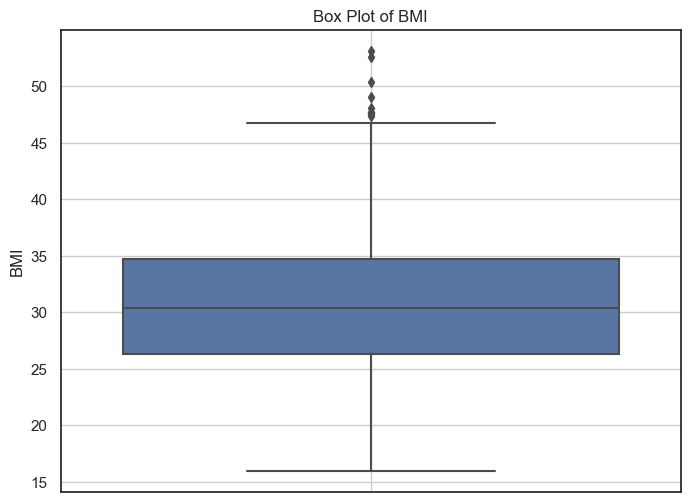

In [27]:
sns.set(style="white")

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="bmi", whis=1.5)
plt.title('Box Plot of BMI')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

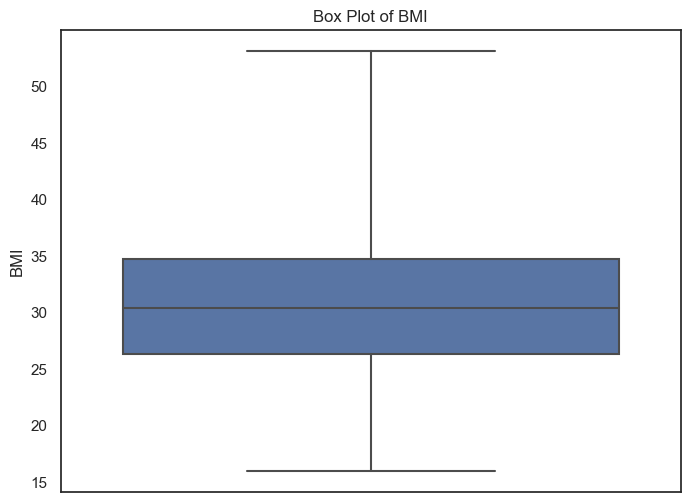

In [28]:
sns.set(style="white")

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="bmi", whis=3)
plt.title('Box Plot of BMI')
plt.ylabel('BMI')
plt.grid(False)
plt.show()

* We can observe we have outliers for bmi score. We need to check these. Bur for whis=3 we don't see any extreme outliers.

In [29]:
df[df["bmi"] > (df["bmi"].quantile(0.75) + (df["bmi"].quantile(0.75) - df["bmi"].quantile(0.25)) * 1.5)]

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


* Somking may increase medical charges.
* We can have more insight but for multiple feature to say clear things, we need to check visulazations more.

## Examine the relationship between “bmi” and “charges”.

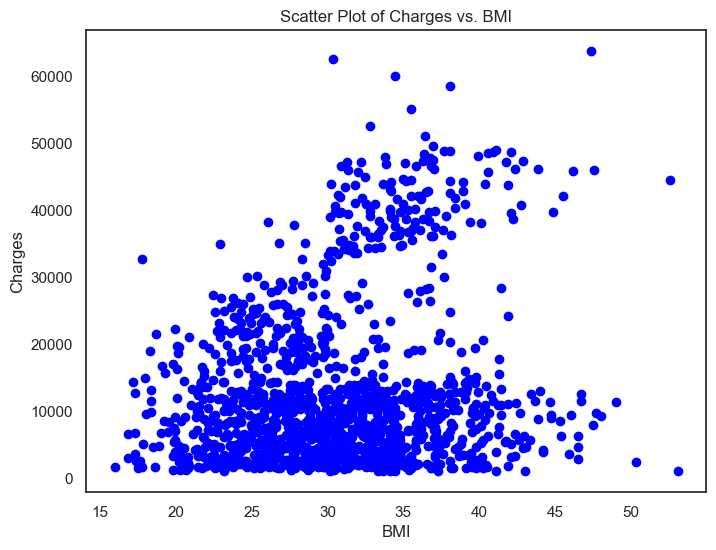

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(df["bmi"],df["charges"],  color='blue', marker='o')
plt.title('Scatter Plot of Charges vs. BMI')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.grid(False)
plt.show()

* BMI may effect the medical charges but we still have outliers for this comment. Person who has bmi value 53.13, also has lower medikal charge.

## Examine the relationship between “region”, “smoker” and “bmi” using bar plot.

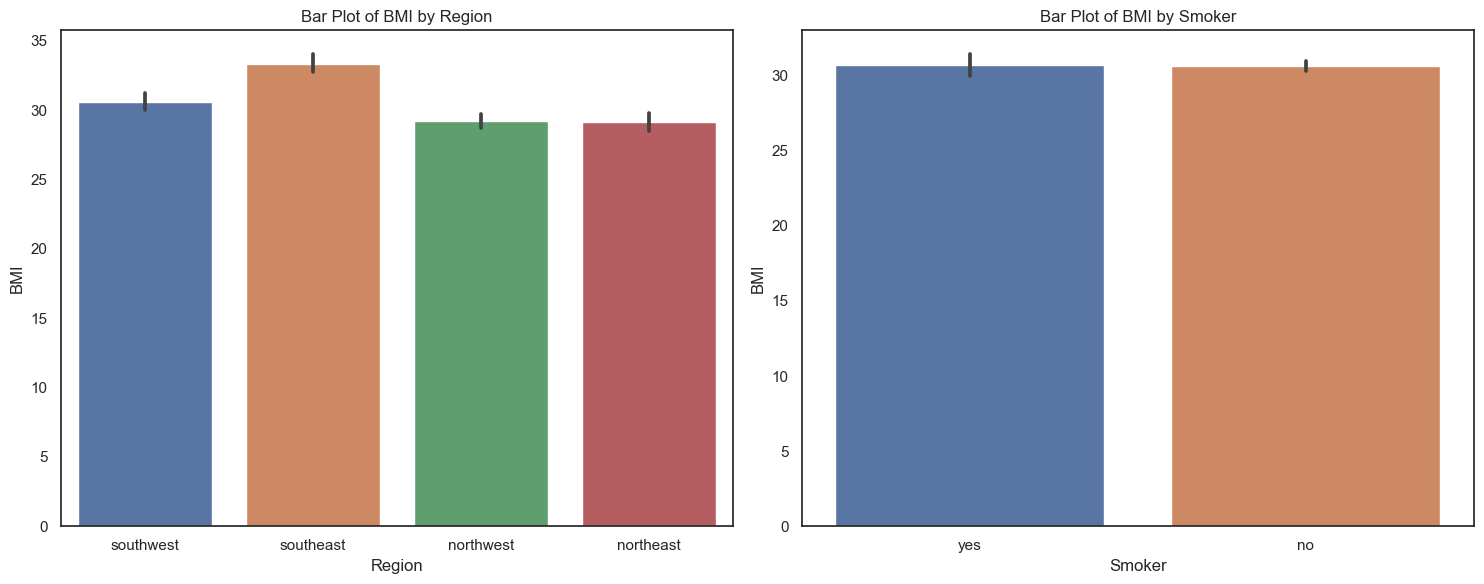

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first bar plot
sns.barplot(x="region", y="bmi", data=df, ax=axes[0])
axes[0].set_title('Bar Plot of BMI by Region')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('BMI')
axes[0].grid(False)

# Plot the second bar plot
sns.barplot(x="smoker", y="bmi", data=df, ax=axes[1])
axes[1].set_title('Bar Plot of BMI by Smoker')
axes[1].set_xlabel('Smoker')
axes[1].set_ylabel('BMI')
axes[1].grid(False)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

* Smoking seems to not effecting the bmi values.
* According to regions people in which live southeast, have biggeer bmi value.

# Data Preprocessing

## Train Test Split

In [32]:
X = df.drop(columns="charges")
y = df.charges

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Encoding

In [34]:
cat_onehot = ['sex', 'smoker', 'region']

In [35]:
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer((OneHotEncoder(handle_unknown="ignore", drop="first"), cat_onehot), 
                                       remainder=StandardScaler())

In [36]:
X_train_trans = column_trans.fit_transform(X_train)
X_test_trans = column_trans.transform(X_test)

In [37]:
features = column_trans.get_feature_names_out()
X_train= pd.DataFrame(X_train_trans, columns=features, index=X_train.index)
X_train.head()

,onehotencoder__sex_male,onehotencoder__smoker_yes,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,remainder__age,remainder__bmi,remainder__children
804,1.0,0.0,0.0,1.0,0.0,-1.157860,-0.688828,-0.927852
354,0.0,0.0,0.0,1.0,0.0,-1.516632,1.245184,-0.927852
563,1.0,0.0,0.0,1.0,0.0,0.779507,2.311602,-0.096360
1177,0.0,0.0,0.0,0.0,1.0,0.061964,-0.542586,-0.096360
390,1.0,0.0,0.0,0.0,0.0,0.635998,0.808922,2.398118


In [38]:
X_test= pd.DataFrame(X_test_trans, columns=features, index=X_test.index)
X_test.head()

,onehotencoder__sex_male,onehotencoder__smoker_yes,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,remainder__age,remainder__bmi,remainder__children
44,1.0,0.0,0.0,0.0,0.0,-0.081545,1.043074,-0.096360
134,0.0,0.0,0.0,0.0,0.0,-1.373123,-0.315007,-0.927852
980,1.0,0.0,0.0,0.0,0.0,1.066524,-0.861361,-0.096360
618,0.0,1.0,0.0,1.0,0.0,-1.444877,0.395665,-0.927852
1238,1.0,0.0,0.0,0.0,0.0,-0.153299,-1.314055,1.566625


In [39]:
corr_by_charges = X_train.join(y_train).corr()["charges"].sort_values(ascending = False)[1:]
corr_by_charges # target ile en yüksek ilişkili sütun smokers

onehotencoder__smoker_yes          0.790116
remainder__age                     0.286538
remainder__bmi                     0.202980
remainder__children                0.079607
onehotencoder__sex_male            0.071838
onehotencoder__region_southeast    0.065162
onehotencoder__region_northwest   -0.021287
onehotencoder__region_southwest   -0.045302
Name: charges, dtype: float64

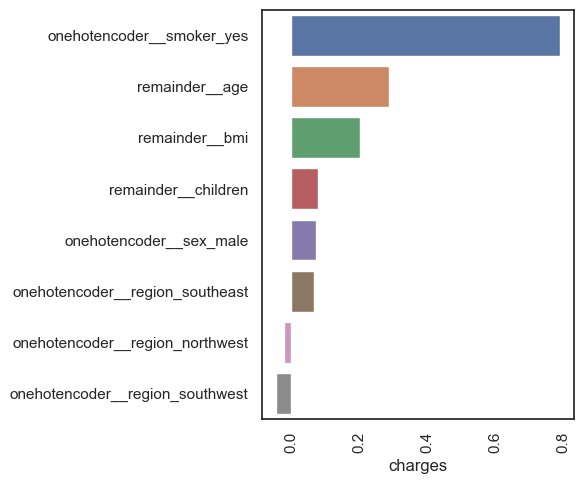

In [40]:
plt.figure(figsize = (6,5))
sns.barplot(y = corr_by_charges.index, x = corr_by_charges)
plt.xticks(rotation=90)
plt.tight_layout();


# Model Selection

## Lazy Predict

In [42]:
#!pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose = 0, ignore_warnings = False, custom_metric = None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
predictions

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:54<00:00,  2.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score 13381.982702


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:54<00:00,  2.72s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.86,0.86,4424.48,0.22
HistGradientBoostingRegressor,0.84,0.84,4703.08,1.09
RandomForestRegressor,0.84,0.84,4742.41,1.05
BaggingRegressor,0.84,0.84,4747.43,0.17
LGBMRegressor,0.84,0.84,4749.55,1.65
XGBRegressor,0.82,0.82,5019.12,0.30
ExtraTreesRegressor,0.81,0.82,5089.12,0.70
AdaBoostRegressor,0.81,0.82,5099.26,0.11
KNeighborsRegressor,0.79,0.80,5348.87,0.04


In [43]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

In [54]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [41]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

# Random Forrest

In [51]:
param_grid2 = {'rf__n_estimators':[50, 64, 100, 128, 300],    
             'rf__max_features':[2, 3, 4, "auto"],
             'rf__max_depth':[3, 5, 7, 9,20],
             'rf__min_samples_split':[2, 5, 8]}

In [53]:
operations_rf = [("rf", RandomForestRegressor(random_state=101))]

model = Pipeline(steps=operations_rf)
rf_pipe = GridSearchCV(model, param_grid2,scoring="neg_mean_squared_error", verbose=False, n_jobs=-1)
rf_pipe.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(random_state=101))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5, 7, 9, 20],
                         'rf__max_features': [2, 3, 4, 'auto'],
                         'rf__min_samples_split': [2, 5, 8],
                         'rf__n_estimators': [50, 64, 100, 128, 300]},
             scoring='neg_mean_squared_error', verbose=False)

In [54]:
rf_pipe.best_params_

{'rf__max_depth': 7,
 'rf__max_features': 4,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 50}

In [55]:
train_val(rf_pipe, X_train, y_train, X_test, y_test)

,train,test
R2,0.91,0.86
mae,2038.65,2593.31
mse,13257333.77,19750107.90
rmse,3641.06,4444.11


* Overfit was observed here. We will try to correct the overfit with optimization by changing the parameters.

## Hyper-parameter Optimization

In [43]:
param_grid3 = {'rf__n_estimators':[50, 64, 100, 128],    
             'rf__max_features':[2, 3, 4,5, "auto"],
             'rf__max_depth':[5, 7, 9,20],
             'rf__min_samples_split':[ 5, 8]}

In [44]:
operations_rf = [("rf", RandomForestRegressor(random_state=101))]

model = Pipeline(steps=operations_rf)
rf_pipe2 = GridSearchCV(model, param_grid3,scoring="neg_mean_squared_error", verbose=False, n_jobs=-1)
rf_pipe2.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(random_state=101))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 7, 9, 20],
                         'rf__max_features': [2, 3, 4, 5, 'auto'],
                         'rf__min_samples_split': [5, 8],
                         'rf__n_estimators': [50, 64, 100, 128]},
             scoring='neg_mean_squared_error', verbose=False)

In [45]:
rf_pipe2.best_params_

{'rf__max_depth': 5,
 'rf__max_features': 5,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 128}

## Model Evaluation

In [55]:
train_val(rf_pipe2, X_train, y_train, X_test, y_test)

,train,test
R2,8.848704e-01,8.608028e-01
mae,2.302046e+03,2.606526e+03
mse,1.702090e+07,1.964219e+07
rmse,4.125639e+03,4.431951e+03


* Optimization eliminated overfit

# Ada Boosting

In [49]:
from sklearn.ensemble import AdaBoostRegressor

In [47]:
param_grid = {"n_estimators":[50, 100, 200, 300, 500],
              "learning_rate":[0.1, 0.5, 0.8, 1],
              "loss": ["linear", "square"]
            }

In [50]:
model = AdaBoostRegressor(random_state=101)
grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1)

In [51]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=AdaBoostRegressor(random_state=101), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.8, 1],
                         'loss': ['linear', 'square'],
                         'n_estimators': [50, 100, 200, 300, 500]},
             scoring='neg_root_mean_squared_error')

In [52]:
grid_model.best_params_

{'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}

## Model Evaluation

In [56]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,8.410050e-01,8.285267e-01
mae,3.903284e+03,4.070886e+03
mse,2.350601e+07,2.419669e+07
rmse,4.848300e+03,4.919013e+03


In [64]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

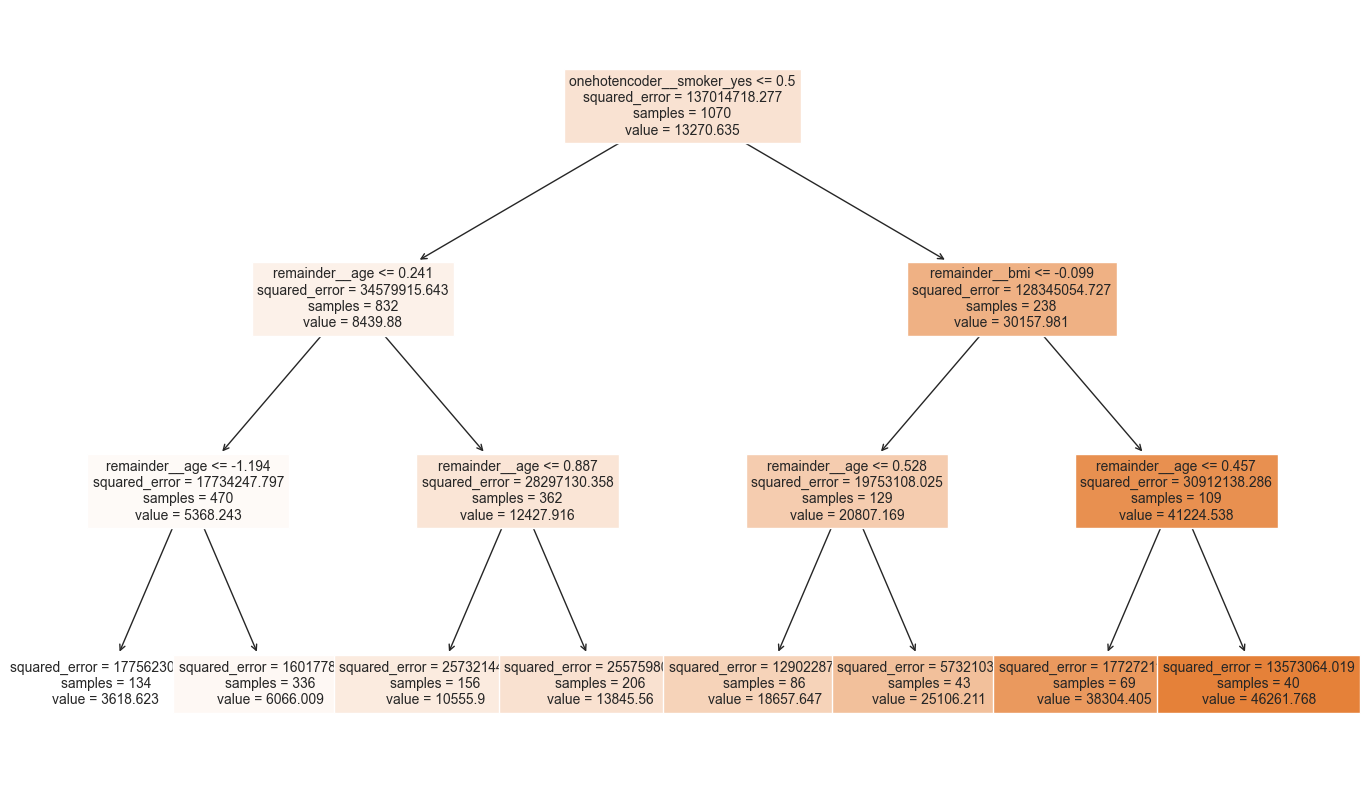

In [77]:
model = AdaBoostRegressor(random_state=101, n_estimators=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(17,10),dpi=100)
plot_tree(model.estimators_[0], filled=True, feature_names=list(X_train.columns), fontsize=10);

# XGBOOST

In [67]:
from xgboost import XGBRegressor

In [65]:
param_grid = {"n_estimators":[100, 300,500],'max_depth':[3,5,6,7], "learning_rate": [0.05, 0.1, 0.2],
             "subsample":[0.5, 1], "colsample_bytree":[0.5, 1]}

In [68]:
model = XGBRegressor(random_state=101, objective="reg:squarederror")
grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1)

In [69]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=101, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 6, 7],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.5, 1]},
             scoring='neg_root_mean_squared_error')

In [70]:
grid_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.5}

## Model Evaluation

In [71]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,8.848139e-01,8.625137e-01
mae,2.190089e+03,2.406918e+03
mse,1.702926e+07,1.940076e+07
rmse,4.126652e+03,4.404629e+03


### Feature Importance

In [72]:
model = XGBRegressor(random_state=101, objective="reg:squarederror",colsample_bytree =1,
 learning_rate = 0.05,
 max_depth = 3,
 n_estimators = 100,
 subsample = 0.5)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=101, ...)

In [73]:
model.feature_importances_

array([0.00743202, 0.8232046 , 0.01439878, 0.01045217, 0.01242846,
       0.04269883, 0.07224221, 0.01714287], dtype=float32)

In [74]:
imp_feats = pd.DataFrame(index=X_train.columns,data=model.feature_importances_,columns=['xgb_Importance'])
xgb_imp_feats = imp_feats.sort_values('xgb_Importance')
xgb_imp_feats

,xgb_Importance
onehotencoder__sex_male,0.007432
onehotencoder__region_southeast,0.010452
onehotencoder__region_southwest,0.012428
onehotencoder__region_northwest,0.014399
remainder__children,0.017143
remainder__age,0.042699
remainder__bmi,0.072242
onehotencoder__smoker_yes,0.823205


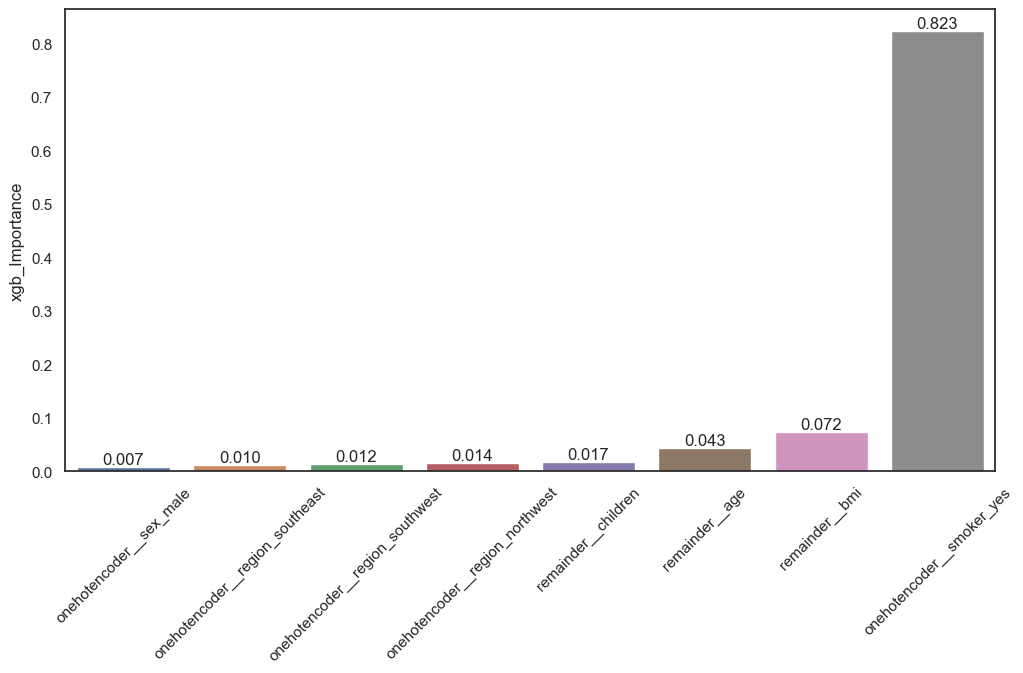

In [75]:

plt.figure(figsize=(12, 6))

ax = sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y='xgb_Importance')
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=45);

* The most influential feature eda has been smoker as predicted as a result.

#  Gradient Boosting - Final Model

* Since the Gradient Boosting model had the highest R2 score, this model was selected as the final model.
* No overfit was observed in this model. CV results are consistent with train.

In [46]:
param_grid = {"gb__n_estimators":[100, 200, 300], "gb__subsample":[0.8, 1], "gb__max_features" : [None, 2, 3, 4],
            "gb__learning_rate": [0.001, 0.01, 0.1, 0.5], 'gb__max_depth':[2,3]
             }

In [47]:
operations = [("gb", GradientBoostingRegressor(random_state = 101))]

gbr_pipe = Pipeline(steps=operations)
gbr_pipe = GridSearchCV(gbr_pipe, param_grid, scoring="neg_mean_squared_error", verbose=False, n_jobs=-1).fit(X_train, y_train)


In [48]:
gbr_pipe.best_params_

{'gb__learning_rate': 0.1,
 'gb__max_depth': 2,
 'gb__max_features': None,
 'gb__n_estimators': 100,
 'gb__subsample': 1}

## Model Evaluation

In [49]:
train_val(gbr_pipe, X_train, y_train, X_test, y_test)

,train,test
R2,0.88,0.87
mae,2269.54,2466.79
mse,17190123.80,18981174.67
rmse,4146.10,4356.74


 **Anıl Mehmet UYAR & Merve ÖZKAN**